# Verify the Conv-VAE sensorprocessing

Load a pre-trained model specified by an experiment/run trained by Train-Conv-VAE

This notebook runs a number of visualizations that allow to illustrate the performance of the trained encoding. The verification here primarily happens through visual observation. 

In [1]:
import sys
sys.path.append("..")
# adding the Julian-8897-Conv-VAE-PyTorch into the path
from settings import Config
sys.path.append(Config()["conv_vae"]["code_dir"])
# from encoding_conv_vae.conv_vae import latest_json_and_model

from sensorprocessing import sp_conv_vae
from sensorprocessing import sp_helper

from helper import ui_choose_task, ui_choose_demo
import os
import matplotlib.pyplot as plt
from pathlib import Path
import random

import torch
# Move data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# At some point in the development, this hack was necessary for some reason. 
# It seems that as of Feb 2025, the code runs on Windows and Linux without it.
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

Loading pointer config file: C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml


In [2]:
# Specify the experiment
experiment = "sensorprocessing_conv_vae"
run = "proprio_128" 
exp = Config().get_experiment(experiment, run)
sp = sp_conv_vae.ConvVaeSensorProcessing(exp, device)

Configuration for experiment: sensorprocessing_conv_vae/proprio_128 successfully loaded


## Verify the Conv-VAE by visual reconstruction
We can verify a Conv-VAE model visually based on its ability to recover the input image from the encoding. The intuition here would be that information that is lost during the recovery is not present in the encoding, and thus it won't be usable by the algorithms using this encoding either.

In [3]:
def visualize_VAE(sp, picture_name, axoriginal, axreconstr):
    """Helper function to show the original and the reconstruction in fields of a picture."""
    transform = sp_helper.get_transform_to_robot()
    input, image = sp_helper.load_picturefile_to_tensor(picture_name, transform)
    # Running the input on the output
    output, mu, logvar = sp.model(input)
    # Output: the visual reconstruction
    output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
    # Showing the input and the reconstruction    
    axoriginal.imshow(image)
    axoriginal.set_title("Original")
    axreconstr.imshow(output_for_pic)
    axreconstr.set_title("Reconstruct")
    return output, mu, logvar

In [4]:
# Choose the demonstration (interactively or the on in the exp)
# choice == "interactive"
choice = "experiment-spec"

if choice == "interactive":
    # task_id = None; demo_id = None
    task_id = 5; demo_id = 0
    _, task_dir = ui_choose_task(offer_task_creation=True, task_id=task_id)
    print(task_dir)
    demo_dir = ui_choose_demo(task_dir, demo_id=demo_id)
if choice == "experiment-spec":
    # FIXME write here the 
    demos_top = Path(Config()["demos"]["directory"])
    demo_dir = Path(demos_top, "demos", exp["validation_task"], exp["validation_demo"])

# Choose n pictures from the validation set
n = 6
jpg_files = list(demo_dir.glob("*.jpg"))
randomjpg = random.sample(jpg_files, n)

In [5]:
# This cell simply verifies whether we can run the sensorprocessing on files
for i in range(n):
    z = sp.process_file(randomjpg[i])
    print(f"The encoding of file {randomjpg[i]} is\n {z}")

The encoding of file C:\Users\lboloni\Documents\Code\_TempData\BerryPicker-demos\demos\proprio_sp_validation\2024_12_26__16_44_06\00033_dev2.jpg is
 [-1.86243206e-01  3.15242171e-01 -1.13889575e-02 -2.21963733e-01
  5.93495928e-02 -1.42666161e-01  7.53623396e-02  2.12099358e-01
  5.28508246e-01  1.08145829e-03  8.14224333e-02 -2.46038705e-01
  9.54449475e-02 -2.28676677e-01 -5.52523017e-01  4.71844167e-01
  1.33408517e-01 -3.92365903e-01  1.71196580e-01  8.18947673e-01
  4.15500432e-01  1.40697286e-01  4.31065448e-02  1.54014602e-01
 -2.62826532e-02  2.23861590e-01 -1.30186245e-01  6.82059377e-02
  2.55356766e-02  1.45265069e-02 -4.07081217e-01  3.25826526e-01
  6.31989688e-02  2.15805918e-02 -2.57477611e-01  4.31321621e-01
 -1.19623512e-01  1.33307735e-02 -1.58341497e-01  1.75053522e-01
  2.19554678e-01 -1.71075314e-02  6.85992837e-02 -7.08843768e-02
  1.69252485e-01  7.89982732e-03 -3.25380474e-01 -3.62930931e-02
  5.64042777e-02 -1.17080283e+00  4.72952604e-01 -1.89422384e-01
  9.77

Pictures0
mu=tensor([[-1.8624e-01,  3.1524e-01, -1.1389e-02, -2.2196e-01,  5.9350e-02,
         -1.4267e-01,  7.5362e-02,  2.1210e-01,  5.2851e-01,  1.0815e-03,
          8.1422e-02, -2.4604e-01,  9.5445e-02, -2.2868e-01, -5.5252e-01,
          4.7184e-01,  1.3341e-01, -3.9237e-01,  1.7120e-01,  8.1895e-01,
          4.1550e-01,  1.4070e-01,  4.3107e-02,  1.5401e-01, -2.6283e-02,
          2.2386e-01, -1.3019e-01,  6.8206e-02,  2.5536e-02,  1.4527e-02,
         -4.0708e-01,  3.2583e-01,  6.3199e-02,  2.1581e-02, -2.5748e-01,
          4.3132e-01, -1.1962e-01,  1.3331e-02, -1.5834e-01,  1.7505e-01,
          2.1955e-01, -1.7108e-02,  6.8599e-02, -7.0884e-02,  1.6925e-01,
          7.8998e-03, -3.2538e-01, -3.6293e-02,  5.6404e-02, -1.1708e+00,
          4.7295e-01, -1.8942e-01,  9.7746e-01, -2.3203e-01,  1.5021e+00,
         -2.4568e-01, -6.2627e-02,  1.0968e-01, -2.6763e-01,  4.5498e-03,
          9.2885e-02, -5.2048e-01,  1.7318e-01,  2.4873e-01,  8.0654e-02,
         -1.9592e-01, -2.

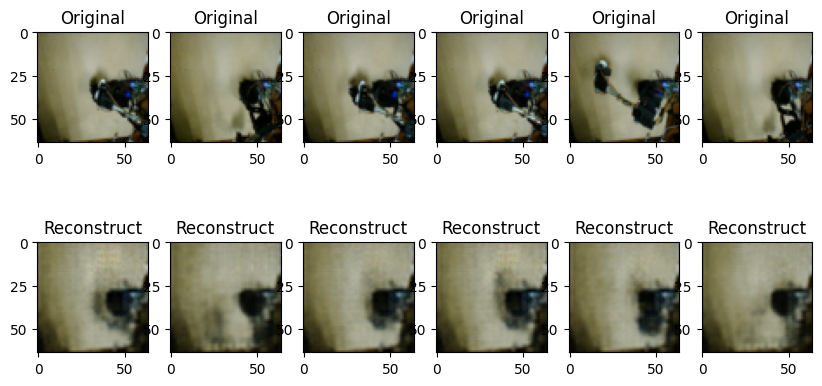

In [6]:
# This cell visualizes the original and reconstructed pictures by going inside 
# the sensorprocessing object and accessing the model
fig, axs = plt.subplots(2, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, randomjpg[i], axs[0,i], axs[1,i])
    print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")

## Reconstruction from noisy latent encoding


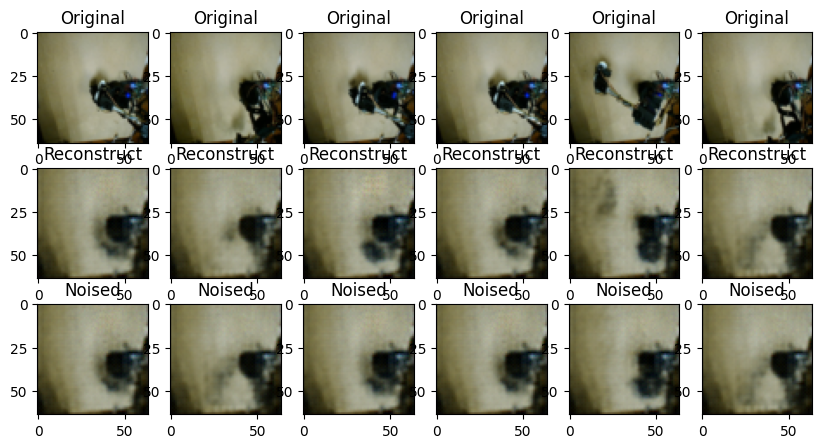

In [7]:
# Visualize the original and reconstructed pictures 
fig, axs = plt.subplots(3, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, randomjpg[i], axs[0,i], axs[1,i])
    # print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")
    # this samples a new z with its logvar
    z2 = sp.model.reparameterize(mu, logvar)
    # adding some noise to the encoding (FIXME: add random noise)
    for j in range(exp["latent_size"]):
        z2[0][j] = z2[0][j] + 0.001
    #output2 = sp.model.decode(z2)
    output2 = sp.model.decode(mu)
    output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
    axs[2,i].imshow(output_for_pic2)
    axs[2,i].set_title("Noised")


# Generating random samples from the model

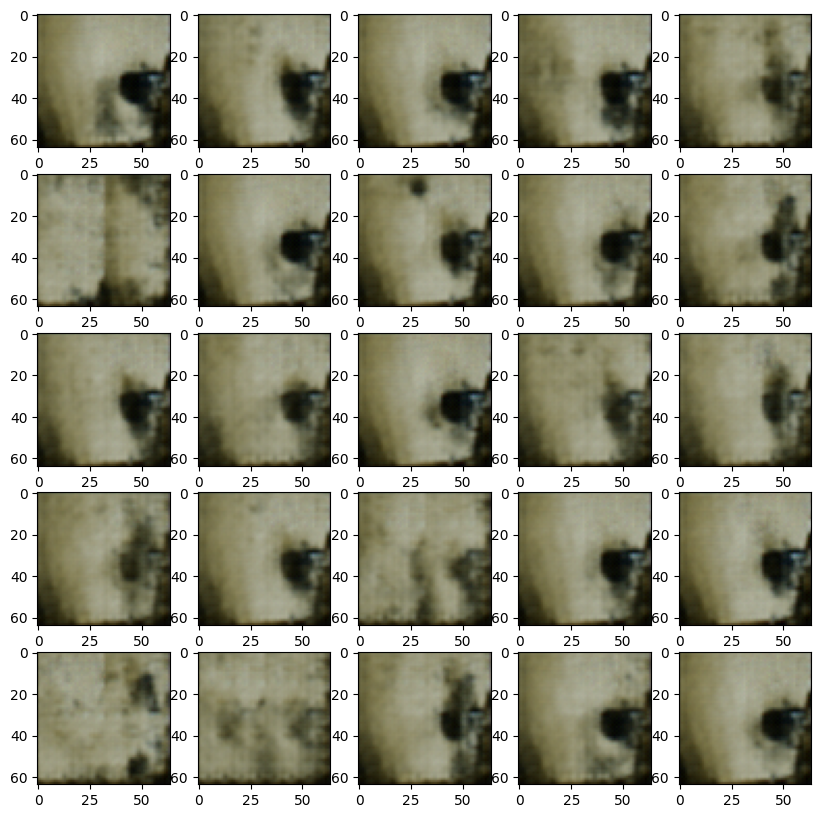

In [8]:

# this can be actually done by just calling sp.model.sample!
samples = sp.model.sample(num_samples = 25, current_device=device)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
i = 0
for x in range(0, 5):
    for y in range(0, 5):
        output_for_pic = samples[i].cpu().permute(1, 2, 0).detach().numpy()
        axs[x][y].imshow(output_for_pic)
        i += 1
